# **0. Setting up dependencies**

In [ ]:
!nvidia-smi

In [ ]:
import torch
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

if cuda_available:
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    
    current_device = torch.cuda.current_device()
    print(f"Current GPU device: {current_device}")
    print(f"Current GPU device name: {torch.cuda.get_device_name(current_device)}")
else:
    print("No CUDA-enabled GPU detected.")

**Install and Import dependencies**

In [ ]:
print(torch.__version__)

In [ ]:
!pip install fastai --quiet
# !pip install fastai==2.7.9 --quiet
!pip install fastbook nbdev --quiet
# !pip install -Uqq fastai nbdev fastbook --quiet

# !pip install --upgrade fastai sentencepiece --quiet
!pip install sentencepiece --quiet
!pip install transformers --quiet
# !pip install ohmeow-blurr

In [ ]:
%cd ..
!git clone https://github.com/ohmeow/blurr.git
%cd blurr
!pip install -e ".[dev]"


In [1]:
import pandas as pd
import numpy as np
import string
import torch
import blurr

from fastai.text.all import *
from transformers import AutoModelForSequenceClassification, AutoConfig

from blurr.text import *
from blurr.text.data.all import *
from blurr.text.modeling import *
from blurr.text.modeling.core import BaseModelWrapper, BaseModelCallback, blurr_splitter

# **1. Importing data**

In [2]:
df = pd.read_csv("/kaggle/input/nlp-project-data/film_details.csv")
df = df.rename(columns={'Plot summary': 'Plot_summary'})
df = df[df['Genres'] != "['']"]
df

,Title,Category,Url,Metascore,Number of critic reviewers,User score,Number of user reviewers,Plot_summary,Genres
0,Dekalog (1988),movie,https://www.metacritic.com/movie/dekalog-1988/,100,13,100,112,"This masterwork by Krzysztof Kieślowski is one of the twentieth century’s greatest achievements in visual storytelling. Originally made for Polish television, Dekalog focuses on the residents of a housing complex in late-Communist Poland, whose lives become subtly intertwined as they face emotional dilemmas that are at once deeply person...",['Drama']
1,The Godfather,movie,https://www.metacritic.com/movie/the-godfather/,100,16,100,4082,"Francis Ford Coppola's epic features Marlon Brando in his Oscar-winning role as the patriarch of the Corleone family. Director Coppola paints a chilling portrait of the Sicilian clan's rise and near fall from power in America, masterfully balancing the story between the Corleone's family life and the ugly crime business in which they are...","['Crime', 'Drama']"
2,Lawrence of Arabia (re-release),movie,https://www.metacritic.com/movie/lawrence-of-arabia-re-release/,100,8,100,442,"The 40th anniversary re-release of David Lean's 1962 masterpiece, starring Peter O'Toole in one of the most electrifying debuts in film history.","['Adventure', 'Biography', 'Drama', 'War']"
3,The Leopard (re-release),movie,https://www.metacritic.com/movie/the-leopard-re-release/,100,12,100,84,"Set in Sicily in 1860, Luchino Visconti's spectacular 1963 adaptation of Giuseppe di Lampedusa's international bestseller is one of the cinema's greatest evocations of the past, achingly depicting the passing of an ancient order. (Film Forum)","['Drama', 'History']"
4,The Conformist,movie,https://www.metacritic.com/movie/the-conformist-re-release/,100,11,100,105,"Set in Rome in the 1930s, this re-release of Bernardo Bertolucci's 1970 breakthrough feature stars Jean-Louis Trintignant as a Mussolini operative sent to Paris to locate and eliminate an old professor who fled Italy when the fascists came to power.",['Drama']
...,...,...,...,...,...,...,...,...,...
15149,Cavemen,tv,https://www.metacritic.com/tv/cavemen/,19,13,19,6,"Cavemen revolves around Joel, his younger brother Andy and best friend Nick. Joel is engaged to Kate. Even though he has some problems with her conservative parents accepting him, he is happy with his life and pursuing the American Dream. The pilot is based on the Geico commercials that claim their service is so easy, ""Even a caveman can...","['Comedy', 'Sci-Fi']"
15150,Work It,tv,https://www.metacritic.com/tv/work-it/,19,22,19,44,"After they are laid off, Lee Standish (Ben Koldyke) and Angel Ortiz (Amaury Nolasco) dress up as women to get new jobs as pharmaceutical sales wo(men).",['Comedy']
15151,Category 7: The End of the World,tv,https://www.metacritic.com/tv/category-7-the-end-of-the-world/,18,11,18,7,"""Category 7: The End of the World"" picks up where ""Category 6: Day of Destruction"" left off. The city of Chicago has been destroyed by a monstrous storm and as the storm gathers strength, it threatens to ravage the rest of the world. A television evangelist and his wife prey on the nation’s fears by broadcasting warnings of biblical pl...","['Action', 'Adventure', 'Drama', 'Sci-Fi', 'Thriller']"
15152,Stalker,tv,https://www.metacritic.com/tv/stalker/,17,24,17,137,"Lt. Beth Davis (Maggie Q) leads the Threat Assessment Unit of the Los Angeles Police Department that includes recent transfer Det. Jack Larsen (McDermott), Det. Ben Caldwell (Victor Rasuk), and Det. Janice Lawrence (Mariana Klaveno).","['Crime', 'Drama', 'Thriller']"


In [3]:
df.shape

(15149, 9)

## Removing rare genres

Rare genres are the genres that has less than 1% frequency in the entire genre count

In [4]:
genres_list = df.Genres.to_list()
genre_count = {}
for genres in genres_list:
  genre_list = eval(genres)
  for genre in genre_list:
    if genre in genre_count.keys():
      genre_count[genre] += 1
    else:
      genre_count[genre] = 1
print(f"Number of Genres: {len(genre_count)}")
print()
print(genre_count)

Number of Genres: 27

{'Drama': 9078, 'Crime': 2788, 'Adventure': 1998, 'Biography': 1306, 'War': 622, 'History': 902, 'Mystery': 2083, 'Romance': 2920, 'Thriller': 4005, 'Film-Noir': 31, 'Comedy': 5257, 'Musical': 356, 'Animation': 619, 'Family': 1036, 'Fantasy': 1522, 'Action': 2606, 'Western': 241, 'Music': 777, 'Documentary': 1354, 'Sport': 462, 'Sci-Fi': 1527, 'Horror': 1579, 'News': 28, 'Unknown': 16, 'Reality-TV': 100, 'Talk-Show': 30, 'Game-Show': 30}


In [5]:
genre_count = df['Genres'].value_counts()
threshold = int(len(df) * 0.01)
rare_genres = [ cat for cat, count in genre_count.items() if count < threshold]
len(rare_genres), rare_genres[:5]

(1807,
 ["['Action', 'Crime', 'Thriller']",
  "['Biography', 'Drama']",
  "['Documentary', 'Biography']",
  "['Horror', 'Thriller']",
  "['Biography', 'Drama', 'History']"])

In [6]:
genres_list = df.Genres.to_list()
revised_genre_list = []
indices_to_drop = []

for idx, genres in enumerate(genres_list):
  genre_list = eval(genres)
  revised_genres = []

  for genre in genre_list:
    if genre not in rare_genres:
      revised_genres.append(genre)

  if len(revised_genres) == 0:
    indices_to_drop.append(idx)
  else:
    revised_genre_list.append(revised_genres)

df = df.drop(indices_to_drop).reset_index(drop=True)
df.shape

(15149, 9)

In [7]:
df['Revised_genres'] = revised_genre_list
df

,Title,Category,Url,Metascore,Number of critic reviewers,User score,Number of user reviewers,Plot_summary,Genres,Revised_genres
0,Dekalog (1988),movie,https://www.metacritic.com/movie/dekalog-1988/,100,13,100,112,"This masterwork by Krzysztof Kieślowski is one of the twentieth century’s greatest achievements in visual storytelling. Originally made for Polish television, Dekalog focuses on the residents of a housing complex in late-Communist Poland, whose lives become subtly intertwined as they face emotional dilemmas that are at once deeply person...",['Drama'],[Drama]
1,The Godfather,movie,https://www.metacritic.com/movie/the-godfather/,100,16,100,4082,"Francis Ford Coppola's epic features Marlon Brando in his Oscar-winning role as the patriarch of the Corleone family. Director Coppola paints a chilling portrait of the Sicilian clan's rise and near fall from power in America, masterfully balancing the story between the Corleone's family life and the ugly crime business in which they are...","['Crime', 'Drama']","[Crime, Drama]"
2,Lawrence of Arabia (re-release),movie,https://www.metacritic.com/movie/lawrence-of-arabia-re-release/,100,8,100,442,"The 40th anniversary re-release of David Lean's 1962 masterpiece, starring Peter O'Toole in one of the most electrifying debuts in film history.","['Adventure', 'Biography', 'Drama', 'War']","[Adventure, Biography, Drama, War]"
3,The Leopard (re-release),movie,https://www.metacritic.com/movie/the-leopard-re-release/,100,12,100,84,"Set in Sicily in 1860, Luchino Visconti's spectacular 1963 adaptation of Giuseppe di Lampedusa's international bestseller is one of the cinema's greatest evocations of the past, achingly depicting the passing of an ancient order. (Film Forum)","['Drama', 'History']","[Drama, History]"
4,The Conformist,movie,https://www.metacritic.com/movie/the-conformist-re-release/,100,11,100,105,"Set in Rome in the 1930s, this re-release of Bernardo Bertolucci's 1970 breakthrough feature stars Jean-Louis Trintignant as a Mussolini operative sent to Paris to locate and eliminate an old professor who fled Italy when the fascists came to power.",['Drama'],[Drama]
...,...,...,...,...,...,...,...,...,...,...
15144,Cavemen,tv,https://www.metacritic.com/tv/cavemen/,19,13,19,6,"Cavemen revolves around Joel, his younger brother Andy and best friend Nick. Joel is engaged to Kate. Even though he has some problems with her conservative parents accepting him, he is happy with his life and pursuing the American Dream. The pilot is based on the Geico commercials that claim their service is so easy, ""Even a caveman can...","['Comedy', 'Sci-Fi']","[Comedy, Sci-Fi]"
15145,Work It,tv,https://www.metacritic.com/tv/work-it/,19,22,19,44,"After they are laid off, Lee Standish (Ben Koldyke) and Angel Ortiz (Amaury Nolasco) dress up as women to get new jobs as pharmaceutical sales wo(men).",['Comedy'],[Comedy]
15146,Category 7: The End of the World,tv,https://www.metacritic.com/tv/category-7-the-end-of-the-world/,18,11,18,7,"""Category 7: The End of the World"" picks up where ""Category 6: Day of Destruction"" left off. The city of Chicago has been destroyed by a monstrous storm and as the storm gathers strength, it threatens to ravage the rest of the world. A television evangelist and his wife prey on the nation’s fears by broadcasting warnings of biblical pl...","['Action', 'Adventure', 'Drama', 'Sci-Fi', 'Thriller']","[Action, Adventure, Drama, Sci-Fi, Thriller]"
15147,Stalker,tv,https://www.metacritic.com/tv/stalker/,17,24,17,137,"Lt. Beth Davis (Maggie Q) leads the Threat Assessment Unit of the Los Angeles Police Department that includes recent transfer Det. Jack Larsen (McDermott), Det. Ben Caldwell (Victor Rasuk), and Det. Janice Lawrence (Mariana Klaveno).","['Crime', 'Drama', 'Thriller']","[Crime, Drama, Thriller]"


In [8]:
revised_genres_list = df.Revised_genres.to_list()
revised_genre_count = {}
for genres in revised_genres_list:
  genre_list = genres
  for genre in genre_list:
    if genre in revised_genre_count.keys():
      revised_genre_count[genre] += 1
    else:
      revised_genre_count[genre] = 1
print(f"Number of Genres: {len(revised_genre_count)}")
print(revised_genre_count)

Number of Genres: 27
{'Drama': 9078, 'Crime': 2788, 'Adventure': 1998, 'Biography': 1306, 'War': 622, 'History': 902, 'Mystery': 2083, 'Romance': 2920, 'Thriller': 4005, 'Film-Noir': 31, 'Comedy': 5257, 'Musical': 356, 'Animation': 619, 'Family': 1036, 'Fantasy': 1522, 'Action': 2606, 'Western': 241, 'Music': 777, 'Documentary': 1354, 'Sport': 462, 'Sci-Fi': 1527, 'Horror': 1579, 'News': 28, 'Unknown': 16, 'Reality-TV': 100, 'Talk-Show': 30, 'Game-Show': 30}


In [9]:
encode_genre_types = { key: idx for idx, (key, value) in enumerate(revised_genre_count.items())}
with open("genre_types_encoded.json", "w") as fp:
  json.dump(encode_genre_types, fp)

In [10]:
# We need this because for multilabel classification all genres have possibility to be present in the predictions
categorical_genre_list = []
revised_genres_list = df.Revised_genres.to_list()

for revised_genres in revised_genres_list:
  categorical_list = [0] * len(encode_genre_types)
  for genre in revised_genres:
    genre_type_index = encode_genre_types[genre] 
    categorical_list[genre_type_index] = 1
  categorical_genre_list.append(categorical_list)

categorical_genre_list[3][:23]

[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [11]:
df['genre_cat_list'] = categorical_genre_list
df

,Title,Category,Url,Metascore,Number of critic reviewers,User score,Number of user reviewers,Plot_summary,Genres,Revised_genres,genre_cat_list
0,Dekalog (1988),movie,https://www.metacritic.com/movie/dekalog-1988/,100,13,100,112,"This masterwork by Krzysztof Kieślowski is one of the twentieth century’s greatest achievements in visual storytelling. Originally made for Polish television, Dekalog focuses on the residents of a housing complex in late-Communist Poland, whose lives become subtly intertwined as they face emotional dilemmas that are at once deeply person...",['Drama'],[Drama],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,The Godfather,movie,https://www.metacritic.com/movie/the-godfather/,100,16,100,4082,"Francis Ford Coppola's epic features Marlon Brando in his Oscar-winning role as the patriarch of the Corleone family. Director Coppola paints a chilling portrait of the Sicilian clan's rise and near fall from power in America, masterfully balancing the story between the Corleone's family life and the ugly crime business in which they are...","['Crime', 'Drama']","[Crime, Drama]","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,Lawrence of Arabia (re-release),movie,https://www.metacritic.com/movie/lawrence-of-arabia-re-release/,100,8,100,442,"The 40th anniversary re-release of David Lean's 1962 masterpiece, starring Peter O'Toole in one of the most electrifying debuts in film history.","['Adventure', 'Biography', 'Drama', 'War']","[Adventure, Biography, Drama, War]","[1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,The Leopard (re-release),movie,https://www.metacritic.com/movie/the-leopard-re-release/,100,12,100,84,"Set in Sicily in 1860, Luchino Visconti's spectacular 1963 adaptation of Giuseppe di Lampedusa's international bestseller is one of the cinema's greatest evocations of the past, achingly depicting the passing of an ancient order. (Film Forum)","['Drama', 'History']","[Drama, History]","[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,The Conformist,movie,https://www.metacritic.com/movie/the-conformist-re-release/,100,11,100,105,"Set in Rome in the 1930s, this re-release of Bernardo Bertolucci's 1970 breakthrough feature stars Jean-Louis Trintignant as a Mussolini operative sent to Paris to locate and eliminate an old professor who fled Italy when the fascists came to power.",['Drama'],[Drama],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...
15144,Cavemen,tv,https://www.metacritic.com/tv/cavemen/,19,13,19,6,"Cavemen revolves around Joel, his younger brother Andy and best friend Nick. Joel is engaged to Kate. Even though he has some problems with her conservative parents accepting him, he is happy with his life and pursuing the American Dream. The pilot is based on the Geico commercials that claim their service is so easy, ""Even a caveman can...","['Comedy', 'Sci-Fi']","[Comedy, Sci-Fi]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
15145,Work It,tv,https://www.metacritic.com/tv/work-it/,19,22,19,44,"After they are laid off, Lee Standish (Ben Koldyke) and Angel Ortiz (Amaury Nolasco) dress up as women to get new jobs as pharmaceutical sales wo(men).",['Comedy'],[Comedy],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
15146,Category 7: The End of the World,tv,https://www.metacritic.com/tv/category-7-the-end-of-the-world/,18,11,18,7,"""Category 7: The End of the World"" picks up where ""Category 6: Day of Destruction"" left off. The city of Chicago has been destroyed by a monstrous storm and as the storm gathers strength, it threatens to ravage the rest of the world. A television evangelist and his wife prey on the nation’s fears by broadcasting warnings of biblical pl...","['Action', 'Adventure', 'Drama', 'Sci

# **2. Dataloaders**

In [12]:
labels = list(encode_genre_types.keys())
labels

['Drama',
 'Crime',
 'Adventure',
 'Biography',
 'War',
 'History',
 'Mystery',
 'Romance',
 'Thriller',
 'Film-Noir',
 'Comedy',
 'Musical',
 'Animation',
 'Family',
 'Fantasy',
 'Action',
 'Western',
 'Music',
 'Documentary',
 'Sport',
 'Sci-Fi',
 'Horror',
 'News',
 'Unknown',
 'Reality-TV',
 'Talk-Show',
 'Game-Show']

In [13]:
model_name = "distilroberta-base"
model_cls = AutoModelForSequenceClassification
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls=model_cls, config=config)
hf_model.config.problem_type = "multi_label_classification"

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

In [14]:
blocks = (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), MultiCategoryBlock(encoded=True,vocab=labels))
dblock = DataBlock(blocks=blocks, get_x=ColReader('Plot_summary'), get_y=ColReader('genre_cat_list'), splitter=RandomSplitter(valid_pct=0.1, seed=42))

In [15]:
dls = dblock.dataloaders(df, bs=32)
torch.save(dls, "dls-multilabel-genre-classifier.pkl")

In [16]:
dls = torch.load("/kaggle/working/dls-multilabel-genre-classifier.pkl")

In [17]:
dls.vocab

['Drama', 'Crime', 'Adventure', 'Biography', 'War', 'History', 'Mystery', 'Romance', 'Thriller', 'Film-Noir', 'Comedy', 'Musical', 'Animation', 'Family', 'Fantasy', 'Action', 'Western', 'Music', 'Documentary', 'Sport', 'Sci-Fi', 'Horror', 'News', 'Unknown', 'Reality-TV', 'Talk-Show', 'Game-Show']

In [18]:
dls.show_batch(dataloaders=dls, max_n=4, trunc_at=512)

,text,target
0,"Four young men from the wrong side of the tracks in New Jersey come together to form the iconic rock group The Four Seasons. The story of their trials and triumphs are accompanied by the songs they made famous, including “Sherry,” “Big Girls Don’t Cry,” “Walk Like a Man,” “Dawn,” “Rag Doll,” “Bye Bye Baby,” “Who Loves You,” and many more...","[Drama, Biography, Music]"
1,"Now that Greg Focker (Stiller) is ""in"" with his soon-to-be in-laws, Jack (De Niro) and Dina (Danner) Byrnes, it looks like smooth sailing for him and his fiancée, Pam (Polo). But that's before Pam's parents meet Greg's parents, Bernie and Roz Focker (Hoffman and Streisand). The hyper-relaxed Fockers and the tightly-wound Byrneses are woe...","[Romance, Comedy]"
2,"We all have a superhero inside us, it just takes a bit of magic to bring it out. In Billy Batson’s (Asher Angel) case, by shouting out one word—SHAZAM!—this streetwise 14-year-old foster kid can turn into the adult Super Hero Shazam (Zachary Levi), courtesy of an ancient wizard. Still a kid at heart—inside a ripped, godlike body—Shazam r...","[Adventure, Comedy, Fantasy, Action]"
3,"A new generation join the world’s top action stars for an adrenaline-fueled adventure in Expend4bles. Reuniting as the team of elite mercenaries, Jason Statham, Dolph Lundgren, Randy Couture, and Sylvester Stallone are joined for the first time by Curtis “50 Cent” Jackson, Megan Fox, Tony Jaa, Iko Uwais, Jacob Scipio, Levy Tran, and Andy...","[Adventure, War, Thriller, Action]"


# **3. Language Modeling**

In [19]:
doc(accuracy_multi)

In [20]:
hf_model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [22]:
model = BaseModelWrapper(hf_model)

acc_mult = partial(accuracy_multi, thresh=0.2)

learner = Learner(dls, 
                  model,
                  opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
                  loss_func=BCEWithLogitsLossFlat(),
                  metrics=[acc_mult],
                  cbs=[BaseModelCallback],
                  splitter=blurr_splitter
                  ).to_fp16()

**Stage 0**

In [24]:
learner.freeze()

Suggested learning rate (slide): 0.0010000000474974513
Suggested learning rate (valley): 0.00015848931798245758
Average learning rate: 0.0005792446827399544
Suggested ALR: 0.58e-3


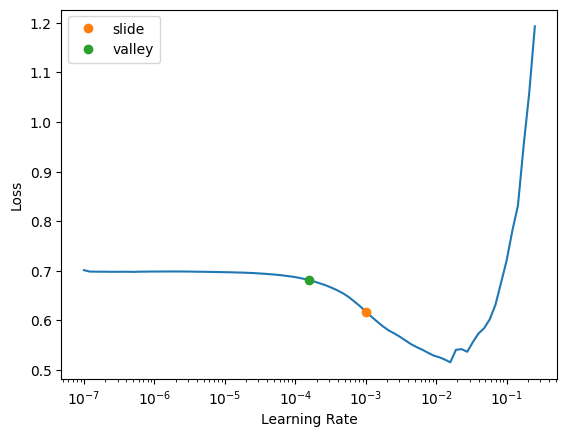

In [25]:
lr_min, lr_steep = learner.lr_find(suggest_funcs=(
    slide, # suggests a learning rate based on the point where the loss starts to decrease most steeply
    valley # suggests a learning rate based on the point where the loss reaches its lowest value before increasing again
))

print(f"Suggested learning rate (slide): {lr_min}")
print(f"Suggested learning rate (valley): {lr_steep}")
average_lr = (lr_min + lr_steep) / 2
print(f"Average learning rate: {average_lr}")
sugg_alr = round((average_lr*1000),2)
print(f"Suggested ALR: {sugg_alr}e-3")

In [27]:
learner.fit_one_cycle(5, average_lr)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.191131,0.175131,0.900020,00:32
1,0.164933,0.164261,0.900705,00:32
2,0.159237,0.156664,0.913596,00:32
3,0.155005,0.153385,0.914722,00:32
4,0.151467,0.152810,0.915138,00:32


In [30]:
learner.save(f"mctc-lm-stage-0_epoch_5")
torch.save(dls, "mctc-lm-stage-0_epoch_5.pkl")

**Stage 1**

In [31]:
# learner.load(f"/kaggle/working/models/mctc-lm-stage-0_epoch_5")

In [32]:
learner.unfreeze()

Suggested learning rate (slide): 0.005248074419796467
Suggested learning rate (valley): 2.75422871709452e-06
Average learning rate: 0.0026254143242567807
Suggested ALR: 2.63e-3


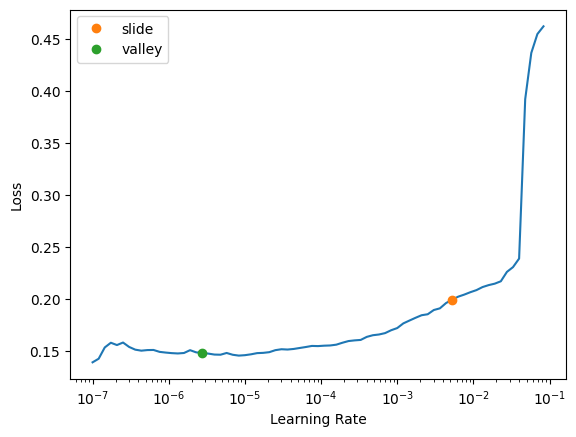

In [33]:
lr_min, lr_steep = learner.lr_find(suggest_funcs=(
    slide, # suggests a learning rate based on the point where the loss starts to decrease most steeply
    valley # suggests a learning rate based on the point where the loss reaches its lowest value before increasing again
))

print(f"Suggested learning rate (slide): {lr_min}")
print(f"Suggested learning rate (valley): {lr_steep}")
average_lr = (lr_min + lr_steep) / 2
print(f"Average learning rate: {average_lr}")
sugg_alr = round((average_lr*1000),2)
print(f"Suggested ALR: {sugg_alr}e-3")

In [34]:
learner.fit_one_cycle(5, slice(lr_min, lr_steep))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.176187,0.175913,0.911640,00:50
1,0.156306,0.178140,0.906967,00:50
2,0.102135,0.185542,0.909022,00:50
3,0.057323,0.193999,0.916557,00:50
4,0.037862,0.197655,0.917853,00:50


In [35]:
learner.save(f"mctc-lm-stage-1_epoch_5")
torch.save(dls, "mctc-lm-stage-1_epoch_5.pkl")

In [36]:
learner.export("models/mctc-lm-stage-1_epoch_5.pkl")

In [39]:
import shutil
shutil.make_archive("film_genre_classifier_multiclass_distilroberta-base", 'zip', '/kaggle/working/')

'/kaggle/working/film_genre_classifier_multiclass_distilroberta-base.zip'